In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from itertools import product

# internal imports
from pympc.geometry.polyhedron import Polyhedron

In [10]:
c_list_1 = [
    np.array([2.,2.]),
    np.array([8.,2.])
]
r_list_1 = [
    np.array([2.,2.]),
    np.array([2.,2.]),
]
c_list_2 = [
    np.array([5.,-1.]),
    np.array([4.5,3.])
]
r_list_2 = [
    np.array([2.,2.]),
    np.array([1.,1.]),
]

In [11]:
def cubes(c_list, r_list):
    return [Polyhedron.from_bounds(c_list[i]-r_list[i], c_list[i]+r_list[i]) for i in range(len(c_list))]

In [12]:
def convex_hull(polytopes):
    n = len(polytopes)
    nx = polytopes[0].A.shape[1]
    A = np.vstack((
        np.hstack([np.eye(nx)] + [-np.eye(nx)]*n + [np.zeros((nx, n))]),
        np.hstack([-np.eye(nx)] + [np.eye(nx)]*n + [np.zeros((nx, n))]),
        np.hstack((np.zeros((1, nx*(n+1))), np.ones((1, n)))),
        np.hstack((np.zeros((1, nx*(n+1))), -np.ones((1, n)))),
        np.hstack((
            np.zeros((sum([polytopes[i].A.shape[0] for i in range(n)]),nx)),
            block_diag(*[polytopes[i].A for i in range(n)]),
            block_diag(*[-np.vstack(polytopes[i].b) for i in range(n)])
        ))
    ))
    b = np.concatenate((
        np.zeros(2*nx),
        np.ones(1),
        -np.ones(1),
        np.zeros(sum([polytopes[i].A.shape[0] for i in range(n)]))
    ))
    return Polyhedron(A,b)

In [13]:
cubes_1 = cubes(c_list_1, r_list_1)
cubes_2 = cubes(c_list_2, r_list_2)

In [14]:
ch_1 = convex_hull(cubes_1)
ch_2 = convex_hull(cubes_2)
ch_1_fs = ch_1.project_to([0,1])
ch_2_fs = ch_2.project_to([0,1])
ch_loose = ch_1_fs.intersection(ch_2_fs)

In [15]:
intersections = [c1.intersection(c2) for (c1, c2) in product(cubes_1, cubes_2)]
intersections = [cube for cube in intersections if not cube.empty]
# c_list_intrs = [c.center for c in intersections]
# r_list_intrs = [c.radius for c in intersections]
ch_fs = convex_hull(intersections)
ch_tight = ch_fs.project_to([0,1])

In [16]:
nx = 2
n = len(c_list_1)
ch_cut = Polyhedron(np.empty((0, nx + nx*n*n + n*n)), np.empty(0))
ch_cut.add_inequality(ch_1.A, ch_1.b, indices=range(nx + nx*n + n))
ch_cut.add_inequality(ch_2.A, ch_2.b, indices=range(nx) + range(nx + nx*n + n, nx + nx*n*n + n*n))
ch_cut.add_inequality(np.array([[1.,1.]]), np.ones(1), indices=[7,13])
ch_cut_fs = ch_cut.project_to([0,1])

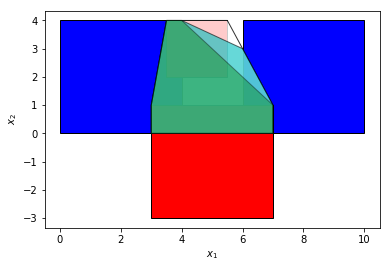

In [17]:
for c in cubes_1:
    c.plot(facecolor='b')
for c in cubes_2:
    c.plot(facecolor='r')
ch_loose.plot(alpha=.8, facecolor='w')
ch_cut_fs.plot(alpha=.6, facecolor='c')
ch_tight.plot(alpha=.4, facecolor='g')